In [1]:
!pip install tpot
!pip install xgboost
!pip install smogn

     |████████████████████████████████| 81kB 2.2MB/s 
     |████████████████████████████████| 163kB 8.1MB/s 
  Created wheel for stopit: filename=stopit-1.1.2-cp36-none-any.whl size=11956 sha256=05c40bb8e3184fde88e26a825ea2eb5b5490e73950f329b32b3666d142eef453
  Stored in directory: /root/.cache/pip/wheels/3c/85/2b/2580190404636bfc63e8de3dff629c03bb795021e1983a6cc7
Successfully built stopit


In [2]:
#Import Packages
import pandas as pd
import numpy as np
from math import sqrt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.linear_model import Lasso, Ridge 
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, accuracy_score, precision_score, make_scorer, f1_score, recall_score
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:
def duplicate_columns(frame):
    groups = frame.columns.to_series().groupby(frame.dtypes).groups
    dups = []

    for t, v in groups.items():

        cs = frame[v].columns
        vs = frame[v]
        lcs = len(cs)

        for i in range(lcs):
            iv = vs.iloc[:,i].tolist()
            for j in range(i+1, lcs):
                jv = vs.iloc[:,j].tolist()
                if iv == jv:
                    dups.append(cs[i])
                    break

    return dups

In [4]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#Read CSV Files
train_regression=pd.read_csv('/content/drive/My Drive/School/Graduate School/Kent State/Spring 2020/Adv Data Mining/Group Project/train_v3(1).csv')
test_1_2=pd.read_csv('/content/drive/My Drive/School/Graduate School/Kent State/Spring 2020/Adv Data Mining/Group Project/test_scenario1_2(1).csv')
test_3=pd.read_csv('/content/drive/My Drive/School/Graduate School/Kent State/Spring 2020/Adv Data Mining/Group Project/test_scenario3(1)(1).csv')

In [0]:
train_regression['default']=np.where(train_regression['loss']>0, 1, 0)

In [7]:
train_regression.head()

,id,f1,f3,f4,f5,f6,f7,f8,f9,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,...,f740,f741,f742,f743,f744,f745,f746,f747,f748,f749,f750,f751,f752,f753,f754,f755,f756,f757,f758,f759,f760,f761,f762,f763,f764,f765,f766,f767,f768,f769,f770,f771,f772,f773,f774,f775,f776,f777,loss,default
0,78539,120,0.146251,2200,4,76878,8703.0,724.0,118.93,14,0.7417,0.7177,11447,0.7236,0.7177,0.4344,0.7177,0.7807,0.7607,1.635298e+09,89,57,895073.0,89.00,89.0,117.60,101.88,89.0,0.8641,0,0,0,10,0,0,0.73885,0.72593,0.741750,10.0,0.050069,...,10.50,11,560.46,4194.28,66239.68,7.0739,0.8750,3.1118,6.5614,5.3389,4.3573,0.044161,3.2096,2.5535,1.3068,0.6737,0.047333,6.3129,5.0343,4.0246,0.038997,8.3261,7.8590,-0.2193,1,0.00,-0.27,-0.050,-0.5810,-5.81,10,3.98,-2.89,2.18,0.2458,0.9434,0,0,0,0
1,61541,154,0.349399,4200,4,76635,2843.0,3253.0,158.08,4,0.7241,0.7241,2211576,0.7241,0.7119,0.5068,0.7241,0.7304,0.7304,4.896017e+09,84,90,1171296.0,121.60,100.5,128.82,103.35,84.0,0.8400,0,0,0,7,0,0,0.71595,0.72071,0.627817,6.0,0.248085,...,21.13,8,261.27,2138.69,21082.83,5.0678,0.7040,1.7046,4.6010,4.0745,3.6322,0.077545,2.7297,1.6436,1.0764,0.7232,0.270885,4.3433,3.7285,3.2183,0.066845,5.0608,4.8213,-0.2696,1,-0.50,-0.62,-0.520,-0.7457,-5.22,7,4.17,-3.50,3.02,0.1991,0.7517,1,1,0,0
2,76531,126,0.975969,1500,10,7399,437.0,1453.0,123.31,15,0.6552,0.6441,1755652,0.6441,0.6441,0.3679,0.6441,0.6909,0.6667,9.149184e+08,76,11,693120.0,76.00,76.0,76.00,76.00,76.0,0.7917,0,0,0,12,0,0,0.63205,0.64969,0.641992,12.0,0.075477,...,-9.47,13,232.84,-833.64,11997.03,4.1689,-0.7084,2.2102,5.9487,4.2542,3.0735,0.071459,2.3640,1.9963,0.8672,0.3910,0.083493,5.7094,3.9969,2.8246,0.068441,6.8826,5.8110,-0.3091,1,-0.56,-0.37,-0.514,-0.3675,-4.41,12,2.25,-1.35,0.89,0.2290,-0.7491,1,0,0,0
3,22066,127,0.951303,3100,7,14448,2681.0,2136.0,128.62,11,0.8034,0.7460,2107744,0.7705,0.7231,0.5738,0.7231,0.8545,0.8174,3.149150e+09,94,72,1192860.0,94.00,94.0,106.08,99.67,94.0,0.9792,0,0,0,12,0,0,0.76155,0.73079,0.754800,12.0,0.042840,...,13.43,13,300.74,2136.02,25856.35,4.6975,0.9707,3.9726,8.3277,6.9576,5.8242,0.037288,4.3737,3.7015,2.0951,1.2006,0.062388,7.9611,6.4995,5.3144,0.031920,10.0889,9.5582,-0.1455,1,-0.62,-0.58,-0.628,-0.5117,-6.14,12,4.06,-3.00,2.31,0.2766,0.4056,0,0,11,1
4,45589,162,0.518486,3500,7,80502,3840.0,130.0,159.78,8,0.8607,0.8607,3973876,0.8607,0.8607,0.7808,0.9052,0.9211,0.8898,6.748954e+09,105,125,1752975.0,158.48,128.2,167.21,131.57,105.0,0.9813,0,0,0,28,0,0,0.61035,0.80463,0.492086,28.0,0.310031,...,21.70,29,1150.51,-2699.14,136997.15,6.2540,-0.9050,5.4722,16.6815,14.0760,11.9681,0.298843,6.6991,7.0544,4.4279,2.8557,0.262708,15.8208,12.9986,10.7595,0.291033,19.5391,18.3984,-0.0789,1,-0.82,-0.71,-0.818,-0.5096,-14.27,28,9.57,-7.15,5.59,0.2864,0.4730,0,1,0,0


In [8]:
len(train_regression)

80000

In [0]:
#Impute Values
imp_train = SimpleImputer(missing_values=np.nan, strategy='median')
imp_test_1_2 = SimpleImputer(missing_values=np.nan, strategy='median')
imp_test_3 = SimpleImputer(missing_values=np.nan, strategy='median')
train_regression=pd.DataFrame(data=imp_train.fit_transform(train_regression), columns=list(train_regression.columns))
test_1_2=pd.DataFrame(data=imp_test_1_2.fit_transform(test_1_2), columns=list(test_1_2.columns))
test_3=pd.DataFrame(data=imp_test_3.fit_transform(test_3), columns=list(test_3.columns))

In [10]:
train_regression.head()

,id,f1,f3,f4,f5,f6,f7,f8,f9,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,...,f740,f741,f742,f743,f744,f745,f746,f747,f748,f749,f750,f751,f752,f753,f754,f755,f756,f757,f758,f759,f760,f761,f762,f763,f764,f765,f766,f767,f768,f769,f770,f771,f772,f773,f774,f775,f776,f777,loss,default
0,78539.0,120.0,0.146251,2200.0,4.0,76878.0,8703.0,724.0,118.93,14.0,0.7417,0.7177,11447.0,0.7236,0.7177,0.4344,0.7177,0.7807,0.7607,1.635298e+09,89.0,57.0,895073.0,89.00,89.0,117.60,101.88,89.0,0.8641,0.0,0.0,0.0,10.0,0.0,0.0,0.73885,0.72593,0.741750,10.0,0.050069,...,10.50,11.0,560.46,4194.28,66239.68,7.0739,0.8750,3.1118,6.5614,5.3389,4.3573,0.044161,3.2096,2.5535,1.3068,0.6737,0.047333,6.3129,5.0343,4.0246,0.038997,8.3261,7.8590,-0.2193,1.0,0.00,-0.27,-0.050,-0.5810,-5.81,10.0,3.98,-2.89,2.18,0.2458,0.9434,0.0,0.0,0.0,0.0
1,61541.0,154.0,0.349399,4200.0,4.0,76635.0,2843.0,3253.0,158.08,4.0,0.7241,0.7241,2211576.0,0.7241,0.7119,0.5068,0.7241,0.7304,0.7304,4.896017e+09,84.0,90.0,1171296.0,121.60,100.5,128.82,103.35,84.0,0.8400,0.0,0.0,0.0,7.0,0.0,0.0,0.71595,0.72071,0.627817,6.0,0.248085,...,21.13,8.0,261.27,2138.69,21082.83,5.0678,0.7040,1.7046,4.6010,4.0745,3.6322,0.077545,2.7297,1.6436,1.0764,0.7232,0.270885,4.3433,3.7285,3.2183,0.066845,5.0608,4.8213,-0.2696,1.0,-0.50,-0.62,-0.520,-0.7457,-5.22,7.0,4.17,-3.50,3.02,0.1991,0.7517,1.0,1.0,0.0,0.0
2,76531.0,126.0,0.975969,1500.0,10.0,7399.0,437.0,1453.0,123.31,15.0,0.6552,0.6441,1755652.0,0.6441,0.6441,0.3679,0.6441,0.6909,0.6667,9.149184e+08,76.0,11.0,693120.0,76.00,76.0,76.00,76.00,76.0,0.7917,0.0,0.0,0.0,12.0,0.0,0.0,0.63205,0.64969,0.641992,12.0,0.075477,...,-9.47,13.0,232.84,-833.64,11997.03,4.1689,-0.7084,2.2102,5.9487,4.2542,3.0735,0.071459,2.3640,1.9963,0.8672,0.3910,0.083493,5.7094,3.9969,2.8246,0.068441,6.8826,5.8110,-0.3091,1.0,-0.56,-0.37,-0.514,-0.3675,-4.41,12.0,2.25,-1.35,0.89,0.2290,-0.7491,1.0,0.0,0.0,0.0
3,22066.0,127.0,0.951303,3100.0,7.0,14448.0,2681.0,2136.0,128.62,11.0,0.8034,0.7460,2107744.0,0.7705,0.7231,0.5738,0.7231,0.8545,0.8174,3.149150e+09,94.0,72.0,1192860.0,94.00,94.0,106.08,99.67,94.0,0.9792,0.0,0.0,0.0,12.0,0.0,0.0,0.76155,0.73079,0.754800,12.0,0.042840,...,13.43,13.0,300.74,2136.02,25856.35,4.6975,0.9707,3.9726,8.3277,6.9576,5.8242,0.037288,4.3737,3.7015,2.0951,1.2006,0.062388,7.9611,6.4995,5.3144,0.031920,10.0889,9.5582,-0.1455,1.0,-0.62,-0.58,-0.628,-0.5117,-6.14,12.0,4.06,-3.00,2.31,0.2766,0.4056,0.0,0.0,11.0,1.0
4,45589.0,162.0,0.518486,3500.0,7.0,80502.0,3840.0,130.0,159.78,8.0,0.8607,0.8607,3973876.0,0.8607,0.8607,0.7808,0.9052,0.9211,0.8898,6.748954e+09,105.0,125.0,1752975.0,158.48,128.2,167.21,131.57,105.0,0.9813,0.0,0.0,0.0,28.0,0.0,0.0,0.61035,0.80463,0.492086,28.0,0.310031,...,21.70,29.0,1150.51,-2699.14,136997.15,6.2540,-0.9050,5.4722,16.6815,14.0760,11.9681,0.298843,6.6991,7.0544,4.4279,2.8557,0.262708,15.8208,12.9986,10.7595,0.291033,19.5391,18.3984,-0.0789,1.0,-0.82,-0.71,-0.818,-0.5096,-14.27,28.0,9.57,-7.15,5.59,0.2864,0.4730,0.0,1.0,0.0,0.0


In [0]:
#Create List For Selective Scaling
train_regression_list=list(train_regression.columns)[1:-2]
test_1_list=list(test_1_2.columns)[2:-1]
test_3_list=list(test_3.columns)[2:-2]

In [0]:
#Scale the Data
scaler_train = StandardScaler()
scaler_test_1_2 = StandardScaler()
scaler_test_3 = StandardScaler()
train_regression[train_regression_list]=scaler_train.fit_transform(train_regression[train_regression_list])
test_1_2[test_1_list]=scaler_test_1_2.fit_transform(test_1_2[test_1_list])
test_3[test_3_list]=scaler_test_3.fit_transform(test_3[test_3_list])

In [13]:
train_regression.head()

,id,f1,f3,f4,f5,f6,f7,f8,f9,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,...,f740,f741,f742,f743,f744,f745,f746,f747,f748,f749,f750,f751,f752,f753,f754,f755,f756,f757,f758,f759,f760,f761,f762,f763,f764,f765,f766,f767,f768,f769,f770,f771,f772,f773,f774,f775,f776,f777,loss,default
0,78539.0,-0.991945,-1.222084,-0.342745,-0.651696,0.808977,2.254264,-0.757715,-1.130273,0.722122,0.186039,0.161859,-0.604158,0.213081,0.275520,-0.439196,0.129189,0.138827,0.139763,-0.666596,0.239068,-0.198088,-0.712228,-0.088789,0.078275,0.331782,0.309501,-0.085883,0.008761,0.0,0.0,0.0,-0.398172,0.0,0.0,0.483893,0.328680,0.612672,-0.397243,-0.838795,...,0.103371,-0.398158,-0.077036,0.125113,-0.150783,1.383933,1.145371,-0.313948,-0.336562,-0.347555,-0.360493,-0.815802,-0.357680,-0.410560,-0.442618,-0.467240,-1.133876,-0.328746,-0.337138,-0.347970,-0.859995,-0.304156,-0.297146,0.138827,0.0,1.653928,1.058991,1.596438,-0.626485,0.304766,-0.398170,-0.277137,0.278464,-0.287780,0.161309,0.894297,-0.669947,-0.691182,0.0,0.0
1,61541.0,1.316486,-0.517746,1.082763,-0.651696,0.802164,-0.049923,0.358784,1.700583,-2.000555,0.113368,0.188375,-0.273153,0.215237,0.251994,-0.021150,0.155856,-0.075062,0.008756,0.909804,0.062009,0.818494,0.205782,0.794738,0.451944,0.605845,0.354563,-0.486130,-0.106021,0.0,0.0,0.0,-0.560925,0.0,0.0,0.365033,0.306260,-0.028373,-0.614175,0.957468,...,0.379249,-0.560869,-0.360122,-0.018523,-0.250607,0.421795,0.932508,-0.501081,-0.483627,-0.456149,-0.431336,-0.524763,-0.417047,-0.538397,-0.491903,-0.451575,2.370794,-0.482795,-0.456892,-0.434136,-0.611262,-0.523603,-0.513108,-0.075062,0.0,-0.101768,-0.734296,-0.183132,-1.786414,0.366044,-0.560922,-0.247787,0.151460,-0.063599,-0.476500,0.708399,1.492655,1.446797,0.0,0.0
2,76531.0,-0.584574,1.654647,-0.841673,0.513581,-1.139153,-0.995977,-0.435877,-0.813564,0.994390,-0.171120,-0.143079,-0.341746,-0.129736,-0.023014,-0.823174,-0.177484,-0.243026,-0.266660,-1.014865,-0.221286,-1.615141,-1.383406,-0.441115,-0.344135,-0.684353,-0.483839,-1.126524,-0.336061,0.0,0.0,0.0,-0.289671,0.0,0.0,-0.070442,0.001232,0.051383,-0.288776,-0.608311,...,-0.414904,-0.289684,-0.387021,-0.226216,-0.270692,-0.009323,-0.825668,-0.433845,-0.382525,-0.440716,-0.485922,-0.577820,-0.462286,-0.488845,-0.536653,-0.556702,-0.566988,-0.375948,-0.432277,-0.476209,-0.597007,-0.401168,-0.442746,-0.243026,0.0,-0.312451,0.546623,-0.160414,0.877126,0.450171,-0.289669,-0.544377,0.599096,-0.632059,-0.068138,-0.746983,1.492655,-0.691182,0.0,0.0
3,22066.0,-0.516679,1.569126,0.298734,-0.069057,-0.941506,-0.113622,-0.134347,-0.429609,-0.094681,0.440798,0.279111,-0.288774,0.415321,0.297423,0.365716,0.151689,0.452643,0.384913,0.065278,0.416128,0.263995,0.277449,0.046722,0.240740,0.050391,0.241754,0.314364,0.556951,0.0,0.0,0.0,-0.289671,0.0,0.0,0.601716,0.349553,0.686098,-0.288776,-0.904371,...,0.179413,-0.289684,-0.322776,-0.018709,-0.240055,0.244197,1.264500,-0.199477,-0.204058,-0.208531,-0.217174,-0.875720,-0.213674,-0.249271,-0.273993,-0.300498,-0.897855,-0.199835,-0.202767,-0.210134,-0.923205,-0.185686,-0.176343,0.452643,0.0,-0.523135,-0.529349,-0.592054,-0.138428,0.270492,-0.289669,-0.264780,0.255562,-0.253085,0.581963,0.372773,-0.669947,-0.691182,11.0,1.0
4,45589.0,1.859646,0.068497,0.583836,-0.069057,0.910591,0.342103,-1.019953,1.823506,-0.911484,0.677389,0.754334,-0.008019,0.804278,0.855552,1.560958,0.910454,0.735843,0.697945,1.805608,0.805658,1.896687,2.138956,1.794262,1.352001,1.543571,1.219634,1.194906,0.566953,0.0,0.0,0.0,0.578340,0.0,0.0,-0.183074,0.666693,-0.792065,0.578953,1.519399,...,0.394042,0.578110,0.481253,-0.356570,0.005633,0.990704,-1.070399,-0.000056,0.422627,0.402840,0.383094,1.404496,0.073992,0.221797,0.225016,0.223271,2.242602,0.414898,0.393257,0.371763,1.391141,0.449420,0.452143,0.735843,0.0,-1.225413,-1.195427,-1.311455,-0.123638,-0.573899,0.578342,0.586371,-0.608480,0.622290,0.715807,0.438133,-0.669947,1.446797,0.0,0.0


In [0]:
#Regression

In [0]:
#Divide into x and y
x=pd.DataFrame(data=train_regression.drop(columns=['id', 'loss', 'default']), columns=train_regression_list)
dup_x_list=duplicate_columns(x)
x=x.drop(columns=dup_x_list)
x=x.loc[:, x.std() > .3]
y=train_regression[['loss']].astype(int)

In [0]:
x_test_1_2=test_1_2.drop(columns=['X', 'id', 'requested_loan'])
x_test_1_2=x_test_1_2[x.columns]
x_test_3=test_3.drop(columns=['X', 'id', 'requested_loan'])
x_test_3=x_test_3[x.columns]

In [0]:
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state = 12, test_size=.15)

In [18]:
x_train.head()

,f1,f3,f4,f5,f6,f8,f9,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f39,f40,f41,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,...,f737,f738,f739,f740,f741,f742,f743,f744,f745,f746,f747,f748,f749,f750,f751,f752,f753,f754,f755,f756,f757,f758,f759,f760,f761,f762,f763,f765,f766,f767,f768,f769,f770,f771,f772,f773,f774,f775,f776,f777
29030,1.520171,-0.179347,0.868937,-0.069057,0.935069,1.443938,1.352058,-0.094681,-0.283015,-0.272346,-0.597671,-0.306104,-0.188911,-0.854932,-0.327903,-0.295329,-0.266660,0.113969,-0.221286,-0.444532,-0.711540,0.341863,0.073401,0.306134,0.052922,-1.126524,-0.592296,-0.695626,-0.199815,-0.685414,1.768243,-0.330693,-1.078068,-0.309740,-1.046834,0.675213,-0.871860,-0.250674,-0.813297,0.633870,...,0.065662,0.642495,0.930889,1.099177,0.632347,0.803680,0.212243,0.075670,1.281201,-0.625128,0.130813,0.261924,0.231601,0.207446,1.904381,0.117995,0.352879,0.319136,0.305803,1.408967,0.254701,0.223568,0.199580,1.890375,0.230155,0.207388,-0.295329,-0.347565,0.111111,-0.345944,0.286246,-0.451343,0.632593,0.410271,-0.373211,0.326050,0.831897,0.401186,-0.669947,1.446797
45342,-0.109309,1.449565,-0.984223,1.678858,0.846718,-0.589953,-0.205454,-0.094681,0.335095,0.383519,-0.597693,0.282938,0.365161,0.297581,0.298359,0.243432,0.332597,-0.875040,0.309892,-0.536948,-0.081645,-0.034585,0.143261,-0.317958,-0.024021,0.074216,0.101158,0.645055,0.414106,0.909650,-0.806591,0.100723,0.506552,0.257168,0.752783,1.115244,0.606455,0.422215,0.876102,1.067904,...,1.466613,1.175705,0.922110,1.423587,1.066244,0.561961,0.419635,0.090450,0.614357,1.003711,1.286579,1.173842,1.153193,1.125782,-0.729521,1.234022,1.155180,1.097726,1.012802,-0.740644,1.215935,1.218488,1.213121,-0.746114,1.176699,1.174154,0.243432,1.021878,0.239203,0.907328,0.031301,-0.965456,1.066598,0.703771,-0.502296,0.336726,-0.415041,-0.701211,-0.669947,-0.691182
31888,-0.924050,-0.955748,-0.770397,1.678858,-1.086131,-0.441616,-0.625563,-0.094681,0.255819,0.331315,-0.001046,0.153142,0.243071,0.302778,0.246274,0.251937,0.341244,-0.675430,0.203656,-0.536948,-0.263966,-0.115891,0.045782,0.108770,0.171862,-0.165932,0.043052,0.463132,0.254806,0.773427,-0.833443,-0.481281,0.512569,0.311102,0.951593,2.270326,0.571852,0.372169,0.749354,2.207245,...,-0.210166,-0.820728,-0.291989,-0.660936,2.205223,2.258769,0.318557,1.397670,1.424315,1.014666,2.055618,2.514495,2.579941,2.639696,-0.585187,2.075731,2.200918,2.094353,1.959802,-0.454896,2.470532,2.518494,2.559400,-0.623659,2.352952,2.358546,0.251937,1.373017,1.468885,1.475276,-0.423656,-2.418474,2.205862,2.501844,-2.557258,2.613237,0.515041,0.631402,1.492655,-0.691182
55741,1.927541,1.095165,1.296590,-1.234334,0.804827,-0.732992,1.662982,1.811193,-2.876437,-2.811702,-0.580089,-2.907201,-2.635589,-0.858396,-2.861285,-3.180910,-3.149232,0.072074,-2.912589,0.664467,-1.297691,-2.500871,-2.813604,-2.540753,-2.813584,-1.686869,-4.106715,-2.987710,-2.789161,-1.746804,1.184169,0.065183,-4.022266,-3.421217,-2.978225,-0.479868,-3.269075,-2.993996,-2.071605,-0.505470,...,1.924617,2.025188,1.340480,0.363937,-0.506632,-0.316834,0.011345,-0.230422,0.569753,1.034085,-0.659876,-0.695710,-0.706550,-0.709238,1.456149,-0.685650,-0.659954,-0.656528,-0.640532,0.540465,-0.691836,-0.702451,-0.704647,1.419142,-0.665306,-0.672835,-3.180910,1.653928,1.930016,1.747891,0.982766,0.615311,-0.506671,-0.637061,0.661557,-0.685436,0.714442,-0.327087,-0.669947,1.446797
29526,-0.109309,1.667452,-1.126774,1.678858,0.846718,-0.202776,-0.257516,-1.183752,0.476307,0.523973,-0.159790,0.423514,0.497392,0.535475,0.522113,0.393962,0.485654,-0.838052,0.451540,0.695272,0.182282,0.073824,0.273233,0.319569,0.409435,0.394413,0.656016,0.522043,0.497171,0.614922,-1.018942,0.533400,0.312197,0.402791,0.405152,-0.809892,0.479852,0.512731,0.578537,-0.830996,...,0.270930,0.369327,0.467497,-0.099838,-0.832055,-0.600582,-0.166635,-0.297100,-1.405025,1.164417,-0.646285,-0.732019,-0.716822,-0.704187,-0.862582,-0.670991,-0.685384,-0.651073,-0.621291,-0.930746,-0.724756,-0

In [19]:
len(x_train)

68000

In [0]:
y_train=pd.DataFrame(data=np.array(y_train[['loss']]), columns=['loss'])
y_test=pd.DataFrame(data=np.array(y_test[['loss']]), columns=['loss'])

In [21]:
x_train['loss']=np.array(y_train[['loss']])
x_test['loss']=np.array(y_test[['loss']])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
x_train=pd.DataFrame(data=x_train.loc[x_train['loss']>0, :], columns=x_train.columns).drop(columns=['loss'])
x_test=pd.DataFrame(data=x_test.loc[x_test['loss']>0, :], columns=x_test.columns).drop(columns=['loss'])

In [0]:
y_train=pd.DataFrame(data=y_train.loc[y_train['loss']>0, :], columns=y_train.columns)
y_test=pd.DataFrame(data=y_test.loc[y_test['loss']>0, :], columns=y_test.columns)

In [0]:
xgboost = xgb.XGBRegressor(objective='reg:squarederror', max_depth=6, random_state=12, learning_rate=.1, 
                           n_estimators=100, nfold=4)
xgboost.fit(x_train, y_train)
predict_train = xgboost.predict(x_train)
predict_test = xgboost.predict(x_test)

In [25]:
print('Train Root Mean Squared Error: {}'.format(sqrt(mean_squared_error(y_train, predict_train))), 'Train R^2: {}'.format(r2_score(y_train, predict_train))) 

Train Root Mean Squared Error: 3.2541066494705726 Train R^2: 0.9231895738022162


In [26]:
print('Test Root Mean Squared Error: {}'.format(sqrt(mean_squared_error(y_test, predict_test))), 'Test R^2: {}'.format(r2_score(y_test, predict_test))) 

Test Root Mean Squared Error: 8.878500455766854 Test R^2: 0.39443747216177416


In [27]:
np.std(y_test), np.std(y_train)

(loss    11.40933
 dtype: float64, loss    11.741449
 dtype: float64)

In [28]:
test_1_2.head()

,X,id,f1,f3,f4,f5,f6,f7,f8,f9,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,...,f739,f740,f741,f742,f743,f744,f745,f746,f747,f748,f749,f750,f751,f752,f753,f754,f755,f756,f757,f758,f759,f760,f761,f762,f763,f764,f765,f766,f767,f768,f769,f770,f771,f772,f773,f774,f775,f776,f777,requested_loan
0,7933.0,7933.0,-1.058888,-0.657200,-0.839627,-0.649764,-1.271008,-1.135620,0.212094,-0.936807,0.450388,-0.353817,-0.341608,0.233386,-0.334934,-0.241449,-1.134618,-0.314128,-0.393668,-0.338910,-0.901861,-0.313876,-1.465596,-1.526894,-0.506171,-0.425052,-0.738738,-0.557608,-1.360793,-0.700186,0.0,0.0,0.0,-0.670878,0.0,0.0,-0.055819,-0.249425,0.270210,-0.669839,...,0.333190,-0.071116,-0.670748,-0.547568,-0.161083,-0.290854,-0.516829,0.630366,-0.576430,-0.602921,-0.599920,-0.596489,-0.345954,-0.599980,-0.620705,-0.612522,-0.600491,-0.319506,-0.602992,-0.601408,-0.599310,-0.413985,-0.644709,-0.650250,-0.393668,0.0,1.234201,1.010120,1.302529,0.139576,0.665310,-0.670878,-0.661314,0.659880,-0.658192,0.646058,0.495222,1.486048,-0.688303,46529.0
1,101860.0,101860.0,-1.194801,1.010359,-1.126435,1.676872,-1.317317,2.014396,0.215647,-0.700720,-1.463819,-0.254794,-0.203708,0.180912,-0.300416,-0.189468,-0.760307,-0.258460,-0.253430,-0.301016,-1.054053,-0.278856,-0.847072,-1.247752,-0.479087,-0.392791,-0.714380,-0.527180,-1.280811,-0.359677,0.0,0.0,0.0,3.454826,0.0,0.0,0.235765,-0.114554,0.904566,3.454292,...,-0.065450,-0.068337,3.453764,0.975773,-0.130637,-0.058652,0.155097,0.490019,3.894052,3.564593,3.530764,3.488856,-0.217843,3.734184,3.773010,3.758993,3.671374,-0.516627,3.610098,3.610123,3.601226,-0.221297,3.663685,3.679164,-0.253430,0.0,1.058405,0.624287,1.018035,-0.162230,-3.429689,3.454826,3.362068,-3.245419,3.122071,0.516368,0.658077,-0.672926,-0.688303,86547.0
2,62580.0,62580.0,-0.379321,0.843450,-0.839627,1.870758,-0.942948,0.989503,-0.963804,-0.509534,-0.369986,-0.079254,-0.187292,-0.054021,-0.196436,-0.111294,-0.623195,-0.108774,-0.269385,-0.213734,-0.885472,-0.173795,-0.475957,-1.144110,-0.397835,-0.296009,-0.205071,-0.185776,-1.040864,-0.078698,0.0,0.0,0.0,-0.829558,0.0,0.0,-0.024052,-0.082724,0.045271,-0.828460,...,0.947157,-0.048888,-0.829383,-0.591899,-0.168170,-0.293627,-1.413688,-0.847758,-0.684279,-0.751972,-0.743712,-0.735918,-0.922901,-0.711077,-0.723367,-0.696355,-0.668576,-1.621016,-0.744007,-0.734327,-0.725380,-0.952676,-0.776212,-0.776093,-0.269385,0.0,0.320063,1.010120,0.414907,1.531984,0.848956,-0.829558,-0.863843,0.867783,-0.861965,-1.875373,1.500199,1.486048,-0.688303,46267.0
3,1760.0,1760.0,1.659381,1.210925,1.024621,-1.037536,0.892108,-0.268856,-0.103640,1.586279,-0.096528,-0.310035,-0.236952,-0.091137,-0.226266,-0.119353,-0.737745,-0.207740,-0.179951,-0.275045,0.220081,-0.138775,0.668313,-0.529193,0.432292,0.161772,0.142020,0.014746,-0.960881,0.018930,0.0,0.0,0.0,-0.723771,0.0,0.0,-0.545751,-0.090404,-1.051971,-0.722713,...,1.040693,0.054169,-0.723627,-0.570880,-0.159812,-0.292273,-1.067444,1.114987,-0.676372,-0.658044,-0.654434,-0.650269,-0.300188,-0.694606,-0.720958,-0.694300,-0.666591,1.081902,-0.657703,-0.655249,-0.651960,-0.389248,-0.671994,-0.670552,-0.179951,0.0,0.249744,0.444231,0.346628,0.454105,0.731260,-0.723771,-0.735373,0.727143,-0.707829,0.472684,-0.884223,-0.672926,1.452850,64206.0
4,48008.0,48008.0,-0.651148,-0.017597,-0.983031,1.482985,0.813796,-0.065603,0.577120,-0.467530,0.450388,0.347527,0.422587,0.402408,0.458554,0.528199,0.574946,0.419868,0.513683,0.346576,-0.718911,0.351509,-0.352252,0.144916,0.008426,0.187903,-0.275950,0.020528,0.158872,0.317053,0.0,0.0,0.0,-0.089048,0.0,0.0,0.695739,0.569359,0.699499,-0.088231,...,-0.333966,-0.337599,-0.089086,-0.324613,-0.130460,-0.259646,0.005430,1.179561,-0.005975,-0.034639,-0.052506,-0.071820,-0.629544,-0.076918,-0.084614,-0.117323,-0.149924,-0.386831,-0.042563,-0.062729,-0.083766,-0.623245,-0.086852,-0.105813,0.513683,0.0,-0.734712,-0.430324,-0.685138,0.538215,0.230039,-0.089048,-0.315200,

In [29]:
test_3.head()

,X,id,f1,f3,f4,f5,f6,f7,f8,f9,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,...,f740,f741,f742,f743,f744,f745,f746,f747,f748,f749,f750,f751,f752,f753,f754,f755,f756,f757,f758,f759,f760,f761,f762,f763,f764,f765,f766,f767,f768,f769,f770,f771,f772,f773,f774,f775,f776,f777,requested_loan,Proposed_Intrest_Rate
0,7933.0,7933.0,-1.058888,-0.657200,-0.839627,-0.649764,-1.271008,-1.135620,0.212094,-0.936807,0.450388,-0.353817,-0.341608,0.233386,-0.334934,-0.241449,-1.134618,-0.314128,-0.393668,-0.338910,-0.901861,-0.313876,-1.465596,-1.526894,-0.506171,-0.425052,-0.738738,-0.557608,-1.360793,-0.700186,0.0,0.0,0.0,-0.670878,0.0,0.0,-0.055819,-0.249425,0.270210,-0.669839,...,-0.071116,-0.670748,-0.547568,-0.161083,-0.290854,-0.516829,0.630366,-0.576430,-0.602921,-0.599920,-0.596489,-0.345954,-0.599980,-0.620705,-0.612522,-0.600491,-0.319506,-0.602992,-0.601408,-0.599310,-0.413985,-0.644709,-0.650250,-0.393668,0.0,1.234201,1.010120,1.302529,0.139576,0.665310,-0.670878,-0.661314,0.659880,-0.658192,0.646058,0.495222,1.486048,-0.688303,50030.0,2.95
1,101860.0,101860.0,-1.194801,1.010359,-1.126435,1.676872,-1.317317,2.014396,0.215647,-0.700720,-1.463819,-0.254794,-0.203708,0.180912,-0.300416,-0.189468,-0.760307,-0.258460,-0.253430,-0.301016,-1.054053,-0.278856,-0.847072,-1.247752,-0.479087,-0.392791,-0.714380,-0.527180,-1.280811,-0.359677,0.0,0.0,0.0,3.454826,0.0,0.0,0.235765,-0.114554,0.904566,3.454292,...,-0.068337,3.453764,0.975773,-0.130637,-0.058652,0.155097,0.490019,3.894052,3.564593,3.530764,3.488856,-0.217843,3.734184,3.773010,3.758993,3.671374,-0.516627,3.610098,3.610123,3.601226,-0.221297,3.663685,3.679164,-0.253430,0.0,1.058405,0.624287,1.018035,-0.162230,-3.429689,3.454826,3.362068,-3.245419,3.122071,0.516368,0.658077,-0.672926,-0.688303,65975.0,4.18
2,62580.0,62580.0,-0.379321,0.843450,-0.839627,1.870758,-0.942948,0.989503,-0.963804,-0.509534,-0.369986,-0.079254,-0.187292,-0.054021,-0.196436,-0.111294,-0.623195,-0.108774,-0.269385,-0.213734,-0.885472,-0.173795,-0.475957,-1.144110,-0.397835,-0.296009,-0.205071,-0.185776,-1.040864,-0.078698,0.0,0.0,0.0,-0.829558,0.0,0.0,-0.024052,-0.082724,0.045271,-0.828460,...,-0.048888,-0.829383,-0.591899,-0.168170,-0.293627,-1.413688,-0.847758,-0.684279,-0.751972,-0.743712,-0.735918,-0.922901,-0.711077,-0.723367,-0.696355,-0.668576,-1.621016,-0.744007,-0.734327,-0.725380,-0.952676,-0.776212,-0.776093,-0.269385,0.0,0.320063,1.010120,0.414907,1.531984,0.848956,-0.829558,-0.863843,0.867783,-0.861965,-1.875373,1.500199,1.486048,-0.688303,79573.0,2.76
3,1760.0,1760.0,1.659381,1.210925,1.024621,-1.037536,0.892108,-0.268856,-0.103640,1.586279,-0.096528,-0.310035,-0.236952,-0.091137,-0.226266,-0.119353,-0.737745,-0.207740,-0.179951,-0.275045,0.220081,-0.138775,0.668313,-0.529193,0.432292,0.161772,0.142020,0.014746,-0.960881,0.018930,0.0,0.0,0.0,-0.723771,0.0,0.0,-0.545751,-0.090404,-1.051971,-0.722713,...,0.054169,-0.723627,-0.570880,-0.159812,-0.292273,-1.067444,1.114987,-0.676372,-0.658044,-0.654434,-0.650269,-0.300188,-0.694606,-0.720958,-0.694300,-0.666591,1.081902,-0.657703,-0.655249,-0.651960,-0.389248,-0.671994,-0.670552,-0.179951,0.0,0.249744,0.444231,0.346628,0.454105,0.731260,-0.723771,-0.735373,0.727143,-0.707829,0.472684,-0.884223,-0.672926,1.452850,29022.0,4.05
4,48008.0,48008.0,-0.651148,-0.017597,-0.983031,1.482985,0.813796,-0.065603,0.577120,-0.467530,0.450388,0.347527,0.422587,0.402408,0.458554,0.528199,0.574946,0.419868,0.513683,0.346576,-0.718911,0.351509,-0.352252,0.144916,0.008426,0.187903,-0.275950,0.020528,0.158872,0.317053,0.0,0.0,0.0,-0.089048,0.0,0.0,0.695739,0.569359,0.699499,-0.088231,...,-0.337599,-0.089086,-0.324613,-0.130460,-0.259646,0.005430,1.179561,-0.005975,-0.034639,-0.052506,-0.071820,-0.629544,-0.076918,-0.084614,-0.117323,-0.149924,-0.386831,-0.042563,-0.062729,-0.083766,-0.623245,-0.086852,-0.105813,0.513683,0.0,-0.734712,-0.430324,-0.685138,0.538215,0.230039,-0.089048,-0.315200,0.364333,-

In [0]:
#Using pca to prepare the test datasets
test_1_2_addons=test_1_2[['X', 'id', 'requested_loan']]
test_3_addons=test_3[['X', 'id', 'requested_loan', 'Proposed_Intrest_Rate']]
test_1_2=test_1_2.drop(columns=['X', 'id', 'requested_loan'])
test_3=test_3.drop(columns=['X', 'id', 'requested_loan', 'Proposed_Intrest_Rate'])

In [31]:
test_1_2.head()

,f1,f3,f4,f5,f6,f7,f8,f9,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,...,f738,f739,f740,f741,f742,f743,f744,f745,f746,f747,f748,f749,f750,f751,f752,f753,f754,f755,f756,f757,f758,f759,f760,f761,f762,f763,f764,f765,f766,f767,f768,f769,f770,f771,f772,f773,f774,f775,f776,f777
0,-1.058888,-0.657200,-0.839627,-0.649764,-1.271008,-1.135620,0.212094,-0.936807,0.450388,-0.353817,-0.341608,0.233386,-0.334934,-0.241449,-1.134618,-0.314128,-0.393668,-0.338910,-0.901861,-0.313876,-1.465596,-1.526894,-0.506171,-0.425052,-0.738738,-0.557608,-1.360793,-0.700186,0.0,0.0,0.0,-0.670878,0.0,0.0,-0.055819,-0.249425,0.270210,-0.669839,-0.573063,0.576229,...,-0.716872,0.333190,-0.071116,-0.670748,-0.547568,-0.161083,-0.290854,-0.516829,0.630366,-0.576430,-0.602921,-0.599920,-0.596489,-0.345954,-0.599980,-0.620705,-0.612522,-0.600491,-0.319506,-0.602992,-0.601408,-0.599310,-0.413985,-0.644709,-0.650250,-0.393668,0.0,1.234201,1.010120,1.302529,0.139576,0.665310,-0.670878,-0.661314,0.659880,-0.658192,0.646058,0.495222,1.486048,-0.688303
1,-1.194801,1.010359,-1.126435,1.676872,-1.317317,2.014396,0.215647,-0.700720,-1.463819,-0.254794,-0.203708,0.180912,-0.300416,-0.189468,-0.760307,-0.258460,-0.253430,-0.301016,-1.054053,-0.278856,-0.847072,-1.247752,-0.479087,-0.392791,-0.714380,-0.527180,-1.280811,-0.359677,0.0,0.0,0.0,3.454826,0.0,0.0,0.235765,-0.114554,0.904566,3.454292,-0.333226,-1.121046,...,-1.557997,-0.065450,-0.068337,3.453764,0.975773,-0.130637,-0.058652,0.155097,0.490019,3.894052,3.564593,3.530764,3.488856,-0.217843,3.734184,3.773010,3.758993,3.671374,-0.516627,3.610098,3.610123,3.601226,-0.221297,3.663685,3.679164,-0.253430,0.0,1.058405,0.624287,1.018035,-0.162230,-3.429689,3.454826,3.362068,-3.245419,3.122071,0.516368,0.658077,-0.672926,-0.688303
2,-0.379321,0.843450,-0.839627,1.870758,-0.942948,0.989503,-0.963804,-0.509534,-0.369986,-0.079254,-0.187292,-0.054021,-0.196436,-0.111294,-0.623195,-0.108774,-0.269385,-0.213734,-0.885472,-0.173795,-0.475957,-1.144110,-0.397835,-0.296009,-0.205071,-0.185776,-1.040864,-0.078698,0.0,0.0,0.0,-0.829558,0.0,0.0,-0.024052,-0.082724,0.045271,-0.828460,-1.111604,2.189894,...,0.304279,0.947157,-0.048888,-0.829383,-0.591899,-0.168170,-0.293627,-1.413688,-0.847758,-0.684279,-0.751972,-0.743712,-0.735918,-0.922901,-0.711077,-0.723367,-0.696355,-0.668576,-1.621016,-0.744007,-0.734327,-0.725380,-0.952676,-0.776212,-0.776093,-0.269385,0.0,0.320063,1.010120,0.414907,1.531984,0.848956,-0.829558,-0.863843,0.867783,-0.861965,-1.875373,1.500199,1.486048,-0.688303
3,1.659381,1.210925,1.024621,-1.037536,0.892108,-0.268856,-0.103640,1.586279,-0.096528,-0.310035,-0.236952,-0.091137,-0.226266,-0.119353,-0.737745,-0.207740,-0.179951,-0.275045,0.220081,-0.138775,0.668313,-0.529193,0.432292,0.161772,0.142020,0.014746,-0.960881,0.018930,0.0,0.0,0.0,-0.723771,0.0,0.0,-0.545751,-0.090404,-1.051971,-0.722713,0.697201,0.653588,...,0.786587,1.040693,0.054169,-0.723627,-0.570880,-0.159812,-0.292273,-1.067444,1.114987,-0.676372,-0.658044,-0.654434,-0.650269,-0.300188,-0.694606,-0.720958,-0.694300,-0.666591,1.081902,-0.657703,-0.655249,-0.651960,-0.389248,-0.671994,-0.670552,-0.179951,0.0,0.249744,0.444231,0.346628,0.454105,0.731260,-0.723771,-0.735373,0.727143,-0.707829,0.472684,-0.884223,-0.672926,1.452850
4,-0.651148,-0.017597,-0.983031,1.482985,0.813796,-0.065603,0.577120,-0.467530,0.450388,0.347527,0.422587,0.402408,0.458554,0.528199,0.574946,0.419868,0.513683,0.346576,-0.718911,0.351509,-0.352252,0.144916,0.008426,0.187903,-0.275950,0.020528,0.158872,0.317053,0.0,0.0,0.0,-0.089048,0.0,0.0,0.695739,0.569359,0.699499,-0.088231,-0.672171,-0.272703,...,-0.112839,-0.333966,-0.337599,-0.089086,-0.324613,-0.130460,-0.259646,0.005430,1.179561,-0.005975,-0.034639,-0.052506,-0.071820,-0.629544,-0.076918,-0.084614,-0.117323,-0.149924,-0.386831,-0.042563,-0.062729,-0.083766,-0.623245,-0.086852,-0.105813,0.513683,0.0,-0.734712,-0.430324,-0.685138,0.538215,0.

In [0]:
x_test_1_2=test_1_2[x_train.columns]
x_test_3=test_3[x_train.columns]

In [0]:
test_1_2['LGD']=xgboost.predict(x_test_1_2)
test_3['LGD']=xgboost.predict(x_test_3)

In [0]:
#Classification
#Divide into x and y
x=train_regression.drop(columns=['id', 'loss', 'default'])
dup_x_list=duplicate_columns(x)
x=x.drop(columns=dup_x_list)
x=x.loc[:, x.std() > .3]
y=train_regression['default']

In [0]:
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state = 12, test_size=.15)

In [0]:
from sklearn.decomposition import PCA
pca=PCA(.90)
pca.fit(x_train)
x_train = pca.transform(x_train)
x_test = pca.transform(x_test)

In [0]:
x_train = pd.DataFrame(data = x_train, columns = [f for f in range(94)])
x_test = pd.DataFrame(data = x_test, columns = [f for f in range(94)])

In [38]:
x_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93
0,8.231470,0.057976,3.875687,10.717900,2.455455,-4.103636,4.235567,-1.909154,1.053601,-0.741173,-0.555550,-0.710174,-1.610616,-0.475959,-2.114423,2.258683,0.160818,1.022611,3.772044,-1.513830,-0.573086,5.013946,-1.018300,-1.596176,-1.254187,-1.129644,0.743998,4.400938,3.103252,-2.103071,-0.265308,1.940425,2.863923,-0.002356,1.391711,0.090636,1.779682,-0.738805,-1.404734,-0.435585,...,-0.719320,1.365799,0.415693,-0.296748,1.171687,0.328049,-0.329869,-0.600157,-0.004767,-0.270966,-0.344800,-0.388428,-0.593455,-0.502544,-0.141089,1.253001,0.186337,-0.037914,-1.088917,-0.831997,-0.559565,-0.562661,-0.243796,-0.940789,-0.153066,0.482968,-0.515696,0.138206,0.316965,0.217722,-0.140706,-1.012993,-0.923853,-0.055857,-0.302213,-0.001401,0.763237,-1.155467,1.041183,-0.497989
1,10.933857,1.618337,-4.192629,-4.972424,2.657922,0.837063,0.058746,0.264592,0.073743,-0.297202,-2.564860,-0.345889,-2.046360,-0.709252,-2.256470,1.902436,-1.047310,2.582443,-0.748584,-1.164564,0.771049,-2.581957,0.966034,2.257165,0.106802,0.211992,-0.311572,0.635900,1.422581,0.073494,-0.405370,-0.004627,-2.164737,1.191465,0.046069,0.697803,1.274824,0.363566,-0.968265,-1.320961,...,-0.195706,-0.359635,-0.708497,-0.079270,0.048766,0.055657,0.281344,-0.755802,0.510213,0.789134,-1.766077,0.208410,-0.369960,-0.145176,-0.086781,0.274813,0.989351,-1.096128,0.290692,-0.952498,0.978291,0.651964,0.078773,0.921237,0.587864,0.244654,0.443839,0.140245,-0.442233,-0.102404,0.090933,0.037567,-0.094102,0.164399,1.614363,-0.057469,0.692913,0.065198,-0.238174,0.702031
2,20.140556,6.074444,-4.448961,-1.367447,4.017553,3.126987,0.120043,-3.502438,0.621121,-0.962926,-2.440934,0.552162,1.313802,0.716272,-0.063082,-0.789503,0.040668,0.108177,-0.767098,0.295715,2.759179,-1.523298,1.670827,-0.436442,-0.344420,0.704472,0.673806,-0.043215,-0.589228,-1.974639,-0.139199,3.355301,-1.359555,1.641674,-0.227640,0.046802,-0.448782,-0.220969,-0.143995,-0.181755,...,0.235164,-0.366151,0.755473,0.406921,-1.411131,-0.140762,-0.318700,0.025495,0.528599,0.861736,-0.632869,0.444199,-0.575359,0.558609,-0.186710,-0.478581,0.161878,0.290024,-0.100487,-0.563884,-0.465641,-0.040585,-0.358169,-0.875904,-0.616963,-1.212550,-0.770724,-0.667325,0.802296,-0.076227,0.612521,-0.964154,0.196689,1.119397,-0.122885,1.748259,-1.272142,0.735359,0.266069,0.460551
3,3.194103,-18.353462,9.858296,5.825235,5.970544,2.391821,-5.115439,-3.364240,-2.839986,1.303598,0.125439,-0.867716,0.188776,0.609429,3.962599,4.563886,2.692647,-0.648099,-1.308537,-2.407488,-3.199251,-3.893980,1.294562,3.724372,-1.561004,-0.898938,-0.736594,1.271932,0.271322,-1.715473,-0.998205,0.109709,-0.211359,-1.824290,-1.773013,-0.931783,2.767355,0.710888,1.986198,0.550275,...,0.242592,0.978897,0.824426,1.157852,-0.670433,-1.447555,0.455449,-0.267370,1.332015,-0.664500,-0.762459,-1.354684,-0.280593,-0.645279,0.160445,1.362005,0.269262,-0.041095,0.185090,0.128929,1.180791,-0.816820,0.107756,-0.569100,0.908466,-0.226541,-1.213663,0.419060,-0.028885,-0.062226,0.989274,0.499873,0.492501,0.708876,1.058640,0.367283,0.728212,-0.126236,-0.147830,-0.469324
4,-8.640175,-0.280851,-4.659150,-4.460708,-5.447700,0.074563,-4.018021,-0.154485,-1.345847,2.647152,0.839183,0.062455,-1.851433,-2.150126,-0.520857,-0.005194,-0.292233,0.852955,-0.327812,-0.807285,2.224820,-2.354761,-0.796080,0.477671,2.215461,-3.372323,0.291505,0.738954,2.761882,-0.445334,-0.710853,0.064387,0.153891,-3.446539,0.303648,0.363665,-0.451293,0.023436,0.673075,-0.096366,...,-0.442559,1.435347,0.904480,2.028762,0.040021,-0.296349,2.268028,1.225848,-0.793138,-0.052627,0.036915,-0.401532,0.484571,1.540286,-1.168837,0.556066,0.989865,0.068061,0.286788,0.533819,-1.432764,-0.393960,-1.082834,0.340544,-1.353424,0.354943,0.538528,1.194427,1.118695,-0.153656,-0.583945,0.699749,1.2775

In [39]:
from imblearn.over_sampling import SMOTE
sm=SMOTE(random_state=12)
x_train, y_train=sm.fit_resample(x_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:
#With PCA
x_train=pd.DataFrame(data=x_train, columns=[f for f in range(94)])

In [0]:
xgboost_class = xgb.XGBClassifier(random_state=12, learning_rate=0.05,
                                  n_estimators=100, max_depth=7, nfold=5)
xgboost_class.fit(x_train, y_train)
predict_train = xgboost_class.predict(x_train)
predict_test = xgboost_class.predict(x_test)
proba_train = np.array([a[1] for a in xgboost_class.predict_proba(x_train)])
proba_test = np.array([a[1] for a in xgboost_class.predict_proba(x_test)])

In [0]:
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.RdBu):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [43]:
#Metrics for the Model
print('Accuracy of the model on training set: {:.2f}'.format(accuracy_score(y_train, predict_train)))
print('Accuracy of the model on test set: {:.2f}'.format(accuracy_score(y_test, predict_test)))
print('AUC of the model on training set: {:.2f}'.format(roc_auc_score(y_train, proba_train)))
print('AUC of the model on test set: {:.2f}'.format(roc_auc_score(y_test, proba_test)))
print('Classification Report for Training Set')
print(classification_report(y_train, predict_train))
print('Classification Report for Test Set')
print(classification_report(y_test, predict_test))

Accuracy of the model on training set: 0.84
Accuracy of the model on test set: 0.70
AUC of the model on training set: 0.92
AUC of the model on test set: 0.62
Classification Report for Training Set
              precision    recall  f1-score   support

         0.0       0.89      0.77      0.83     61672
         1.0       0.80      0.90      0.85     61672

    accuracy                           0.84    123344
   macro avg       0.84      0.84      0.84    123344
weighted avg       0.84      0.84      0.84    123344

Classification Report for Test Set
              precision    recall  f1-score   support

         0.0       0.93      0.73      0.82     10949
         1.0       0.13      0.41      0.20      1051

    accuracy                           0.70     12000
   macro avg       0.53      0.57      0.51     12000
weighted avg       0.86      0.70      0.76     12000



Confusion matrix, without normalization
[[47567 14105]
 [ 6073 55599]]


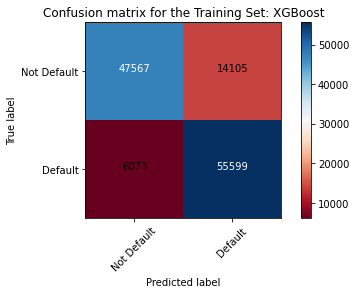

In [44]:
cm_train = confusion_matrix(y_train, predict_train)
plot_confusion_matrix(cm_train, ['Not Default', 'Default'], normalize=False, title='Confusion matrix for the Training Set: XGBoost')

Confusion matrix, without normalization
[[7986 2963]
 [ 616  435]]


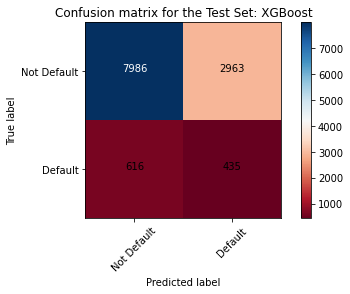

In [45]:
cm_test= confusion_matrix(y_test, predict_test)
plot_confusion_matrix(cm_test, ['Not Default', 'Default'], normalize=False, title='Confusion matrix for the Test Set: XGBoost')

In [0]:
x_test_1_2=pca.transform(x_test_1_2)
x_test_3=pca.transform(x_test_3)
x_test_1_2=pd.DataFrame(data=x_test_1_2, columns=[f for f in range(94)])
x_test_3=pd.DataFrame(data=x_test_3, columns=[f for f in range(94)])

In [0]:
test_1_2['PD']=np.array([a[1] for a in xgboost_class.predict_proba(x_test_1_2)])*100
test_3['PD']=np.array([a[1] for a in xgboost_class.predict_proba(x_test_3)])*100

In [0]:
test_1_2[['X', 'id', 'requested_loan']]=test_1_2_addons
test_3[['X', 'id', 'requested_loan', 'Proposed_Intrest_Rate']]=test_3_addons

In [49]:
test_1_2.head()

,f1,f3,f4,f5,f6,f7,f8,f9,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,...,f743,f744,f745,f746,f747,f748,f749,f750,f751,f752,f753,f754,f755,f756,f757,f758,f759,f760,f761,f762,f763,f764,f765,f766,f767,f768,f769,f770,f771,f772,f773,f774,f775,f776,f777,LGD,PD,X,id,requested_loan
0,-1.058888,-0.657200,-0.839627,-0.649764,-1.271008,-1.135620,0.212094,-0.936807,0.450388,-0.353817,-0.341608,0.233386,-0.334934,-0.241449,-1.134618,-0.314128,-0.393668,-0.338910,-0.901861,-0.313876,-1.465596,-1.526894,-0.506171,-0.425052,-0.738738,-0.557608,-1.360793,-0.700186,0.0,0.0,0.0,-0.670878,0.0,0.0,-0.055819,-0.249425,0.270210,-0.669839,-0.573063,0.576229,...,-0.161083,-0.290854,-0.516829,0.630366,-0.576430,-0.602921,-0.599920,-0.596489,-0.345954,-0.599980,-0.620705,-0.612522,-0.600491,-0.319506,-0.602992,-0.601408,-0.599310,-0.413985,-0.644709,-0.650250,-0.393668,0.0,1.234201,1.010120,1.302529,0.139576,0.665310,-0.670878,-0.661314,0.659880,-0.658192,0.646058,0.495222,1.486048,-0.688303,31.192585,37.427414,7933.0,7933.0,46529.0
1,-1.194801,1.010359,-1.126435,1.676872,-1.317317,2.014396,0.215647,-0.700720,-1.463819,-0.254794,-0.203708,0.180912,-0.300416,-0.189468,-0.760307,-0.258460,-0.253430,-0.301016,-1.054053,-0.278856,-0.847072,-1.247752,-0.479087,-0.392791,-0.714380,-0.527180,-1.280811,-0.359677,0.0,0.0,0.0,3.454826,0.0,0.0,0.235765,-0.114554,0.904566,3.454292,-0.333226,-1.121046,...,-0.130637,-0.058652,0.155097,0.490019,3.894052,3.564593,3.530764,3.488856,-0.217843,3.734184,3.773010,3.758993,3.671374,-0.516627,3.610098,3.610123,3.601226,-0.221297,3.663685,3.679164,-0.253430,0.0,1.058405,0.624287,1.018035,-0.162230,-3.429689,3.454826,3.362068,-3.245419,3.122071,0.516368,0.658077,-0.672926,-0.688303,14.995783,23.077007,101860.0,101860.0,86547.0
2,-0.379321,0.843450,-0.839627,1.870758,-0.942948,0.989503,-0.963804,-0.509534,-0.369986,-0.079254,-0.187292,-0.054021,-0.196436,-0.111294,-0.623195,-0.108774,-0.269385,-0.213734,-0.885472,-0.173795,-0.475957,-1.144110,-0.397835,-0.296009,-0.205071,-0.185776,-1.040864,-0.078698,0.0,0.0,0.0,-0.829558,0.0,0.0,-0.024052,-0.082724,0.045271,-0.828460,-1.111604,2.189894,...,-0.168170,-0.293627,-1.413688,-0.847758,-0.684279,-0.751972,-0.743712,-0.735918,-0.922901,-0.711077,-0.723367,-0.696355,-0.668576,-1.621016,-0.744007,-0.734327,-0.725380,-0.952676,-0.776212,-0.776093,-0.269385,0.0,0.320063,1.010120,0.414907,1.531984,0.848956,-0.829558,-0.863843,0.867783,-0.861965,-1.875373,1.500199,1.486048,-0.688303,32.479424,37.203918,62580.0,62580.0,46267.0
3,1.659381,1.210925,1.024621,-1.037536,0.892108,-0.268856,-0.103640,1.586279,-0.096528,-0.310035,-0.236952,-0.091137,-0.226266,-0.119353,-0.737745,-0.207740,-0.179951,-0.275045,0.220081,-0.138775,0.668313,-0.529193,0.432292,0.161772,0.142020,0.014746,-0.960881,0.018930,0.0,0.0,0.0,-0.723771,0.0,0.0,-0.545751,-0.090404,-1.051971,-0.722713,0.697201,0.653588,...,-0.159812,-0.292273,-1.067444,1.114987,-0.676372,-0.658044,-0.654434,-0.650269,-0.300188,-0.694606,-0.720958,-0.694300,-0.666591,1.081902,-0.657703,-0.655249,-0.651960,-0.389248,-0.671994,-0.670552,-0.179951,0.0,0.249744,0.444231,0.346628,0.454105,0.731260,-0.723771,-0.735373,0.727143,-0.707829,0.472684,-0.884223,-0.672926,1.452850,13.238291,40.850956,1760.0,1760.0,64206.0
4,-0.651148,-0.017597,-0.983031,1.482985,0.813796,-0.065603,0.577120,-0.467530,0.450388,0.347527,0.422587,0.402408,0.458554,0.528199,0.574946,0.419868,0.513683,0.346576,-0.718911,0.351509,-0.352252,0.144916,0.008426,0.187903,-0.275950,0.020528,0.158872,0.317053,0.0,0.0,0.0,-0.089048,0.0,0.0,0.695739,0.569359,0.699499,-0.088231,-0.672171,-0.272703,...,-0.130460,-0.259646,0.005430,1.179561,-0.005975,-0.034639,-0.052506,-0.071820,-0.629544,-0.076918,-0.084614,-0.117323,-0.149924,-0.386831,-0.042563,-0.062729,-0.083766,-0.623245,-0.086852,-0.105813,0.513683,0.0,-0.734712,-0.430324,-0.685138,0.538215,0.230039,-0.089048,-0.315200,0.364333,-0.402168,0.277467,-0.661141,-

In [50]:
test_3.head()

,f1,f3,f4,f5,f6,f7,f8,f9,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,...,f744,f745,f746,f747,f748,f749,f750,f751,f752,f753,f754,f755,f756,f757,f758,f759,f760,f761,f762,f763,f764,f765,f766,f767,f768,f769,f770,f771,f772,f773,f774,f775,f776,f777,LGD,PD,X,id,requested_loan,Proposed_Intrest_Rate
0,-1.058888,-0.657200,-0.839627,-0.649764,-1.271008,-1.135620,0.212094,-0.936807,0.450388,-0.353817,-0.341608,0.233386,-0.334934,-0.241449,-1.134618,-0.314128,-0.393668,-0.338910,-0.901861,-0.313876,-1.465596,-1.526894,-0.506171,-0.425052,-0.738738,-0.557608,-1.360793,-0.700186,0.0,0.0,0.0,-0.670878,0.0,0.0,-0.055819,-0.249425,0.270210,-0.669839,-0.573063,0.576229,...,-0.290854,-0.516829,0.630366,-0.576430,-0.602921,-0.599920,-0.596489,-0.345954,-0.599980,-0.620705,-0.612522,-0.600491,-0.319506,-0.602992,-0.601408,-0.599310,-0.413985,-0.644709,-0.650250,-0.393668,0.0,1.234201,1.010120,1.302529,0.139576,0.665310,-0.670878,-0.661314,0.659880,-0.658192,0.646058,0.495222,1.486048,-0.688303,31.192585,37.427414,7933.0,7933.0,50030.0,2.95
1,-1.194801,1.010359,-1.126435,1.676872,-1.317317,2.014396,0.215647,-0.700720,-1.463819,-0.254794,-0.203708,0.180912,-0.300416,-0.189468,-0.760307,-0.258460,-0.253430,-0.301016,-1.054053,-0.278856,-0.847072,-1.247752,-0.479087,-0.392791,-0.714380,-0.527180,-1.280811,-0.359677,0.0,0.0,0.0,3.454826,0.0,0.0,0.235765,-0.114554,0.904566,3.454292,-0.333226,-1.121046,...,-0.058652,0.155097,0.490019,3.894052,3.564593,3.530764,3.488856,-0.217843,3.734184,3.773010,3.758993,3.671374,-0.516627,3.610098,3.610123,3.601226,-0.221297,3.663685,3.679164,-0.253430,0.0,1.058405,0.624287,1.018035,-0.162230,-3.429689,3.454826,3.362068,-3.245419,3.122071,0.516368,0.658077,-0.672926,-0.688303,14.995783,23.077007,101860.0,101860.0,65975.0,4.18
2,-0.379321,0.843450,-0.839627,1.870758,-0.942948,0.989503,-0.963804,-0.509534,-0.369986,-0.079254,-0.187292,-0.054021,-0.196436,-0.111294,-0.623195,-0.108774,-0.269385,-0.213734,-0.885472,-0.173795,-0.475957,-1.144110,-0.397835,-0.296009,-0.205071,-0.185776,-1.040864,-0.078698,0.0,0.0,0.0,-0.829558,0.0,0.0,-0.024052,-0.082724,0.045271,-0.828460,-1.111604,2.189894,...,-0.293627,-1.413688,-0.847758,-0.684279,-0.751972,-0.743712,-0.735918,-0.922901,-0.711077,-0.723367,-0.696355,-0.668576,-1.621016,-0.744007,-0.734327,-0.725380,-0.952676,-0.776212,-0.776093,-0.269385,0.0,0.320063,1.010120,0.414907,1.531984,0.848956,-0.829558,-0.863843,0.867783,-0.861965,-1.875373,1.500199,1.486048,-0.688303,32.479424,37.203918,62580.0,62580.0,79573.0,2.76
3,1.659381,1.210925,1.024621,-1.037536,0.892108,-0.268856,-0.103640,1.586279,-0.096528,-0.310035,-0.236952,-0.091137,-0.226266,-0.119353,-0.737745,-0.207740,-0.179951,-0.275045,0.220081,-0.138775,0.668313,-0.529193,0.432292,0.161772,0.142020,0.014746,-0.960881,0.018930,0.0,0.0,0.0,-0.723771,0.0,0.0,-0.545751,-0.090404,-1.051971,-0.722713,0.697201,0.653588,...,-0.292273,-1.067444,1.114987,-0.676372,-0.658044,-0.654434,-0.650269,-0.300188,-0.694606,-0.720958,-0.694300,-0.666591,1.081902,-0.657703,-0.655249,-0.651960,-0.389248,-0.671994,-0.670552,-0.179951,0.0,0.249744,0.444231,0.346628,0.454105,0.731260,-0.723771,-0.735373,0.727143,-0.707829,0.472684,-0.884223,-0.672926,1.452850,13.238291,40.850956,1760.0,1760.0,29022.0,4.05
4,-0.651148,-0.017597,-0.983031,1.482985,0.813796,-0.065603,0.577120,-0.467530,0.450388,0.347527,0.422587,0.402408,0.458554,0.528199,0.574946,0.419868,0.513683,0.346576,-0.718911,0.351509,-0.352252,0.144916,0.008426,0.187903,-0.275950,0.020528,0.158872,0.317053,0.0,0.0,0.0,-0.089048,0.0,0.0,0.695739,0.569359,0.699499,-0.088231,-0.672171,-0.272703,...,-0.259646,0.005430,1.179561,-0.005975,-0.034639,-0.052506,-0.071820,-0.629544,-0.076918,-0.084614,-0.117323,-0.149924,-0.386831,-0.042563,-0.062729,-0.083766,-0.623245,-0.086852,-0.105813,0.513683,0.0,-0.734712,-0.430324,-0.685138,0.538215,0.230039,-0.089048,-0.315200,0.364333,-0.402168,0.277467,-0.661141,-0.672926,-0.6

In [0]:
#Expected Loss PD(.01)*Loan Value*LGD
#Expected Gain Loan Value*(rate)*(1-(PD*.01))

In [52]:
#Question 1
#Defining inputs and acceptance thresholds
total_capital=1400000000
interest_rate=4.32
term=5
threshold_results_1=[]
LGD_range=np.arange(1, 100, step=1)
PD_range=np.arange(1, 100, step=1)
#Calculating the Best Acceptance Threshold
for f in PD_range:
  for g in LGD_range:
    df=test_1_2.loc[(test_1_2['LGD']<g)&(test_1_2['PD']<f), :]
    if sum(df['requested_loan'])<=total_capital:
      df['Expected Gain']=(df['requested_loan']*interest_rate*(1-(df['PD']*.01)))
      df['Expected Loss']=((df['PD']*.01)*df['requested_loan']*df['LGD'])
      df['Net Return']=df['Expected Gain']-df['Expected Loss']
      threshold_results_1.append([f, g, sum(df['requested_loan']), sum(df['Net Return']), sum(df['Expected Gain']), sum(df['Expected Loss'])])
    else:
      pass
threshold_df_1=pd.DataFrame(data=threshold_results_1, columns=['PD', 'LGD', 'Total Loan', 'Net Return', 'Expected Gain', 'Expected Loss'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [53]:
#Question 2
#Defining inputs and acceptance thresholds
total_capital=450000000
interest_rate=4.32
term=5
threshold_results_2=[]
LGD_range=np.arange(1, 100, step=1)
PD_range=np.arange(1, 100, step=1)
#Calculating the Best Acceptance Threshold
for f in PD_range:
  for g in LGD_range:
    df=test_1_2.loc[(test_1_2['LGD']<g)&(test_1_2['PD']<f), :]
    if sum(df['requested_loan'])<=total_capital:
      df['Expected Gain']=(df['requested_loan']*interest_rate*(1-(df['PD']*.01)))
      df['Expected Loss']=((df['PD']*.01)*df['requested_loan']*df['LGD'])
      df['Net Return']=df['Expected Gain']-df['Expected Loss']
      threshold_results_2.append([f, g, sum(df['requested_loan']), sum(df['Net Return']), sum(df['Expected Gain']), sum(df['Expected Loss'])])
    else:
      pass
threshold_df_2=pd.DataFrame(data=threshold_results_2, columns=['PD', 'LGD', 'Total Loan', 'Net Return', 'Expected Gain', 'Expected Loss'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [54]:
#Question 3
#Defining inputs and acceptance thresholds
total_capital=1400000000
term=5
threshold_results_3=[]
LGD_range=np.arange(1, 100, step=1)
PD_range=np.arange(1, 100, step=1)
#Calculating the Best Acceptance Threshold
for f in PD_range:
  for g in LGD_range:
    df=test_3.loc[(test_3['LGD']<g)&(test_3['PD']<f), :]
    if sum(df['requested_loan'])<=total_capital:
      df['Expected Gain']=(df['requested_loan']*df['Proposed_Intrest_Rate']*(1-(df['PD']*.01)))
      df['Expected Loss']=((df['PD']*.01)*df['requested_loan']*df['LGD'])
      df['Net Return']=df['Expected Gain']-df['Expected Loss']
      threshold_results_3.append([f, g, sum(df['requested_loan']), sum(df['Net Return']), sum(df['Expected Gain']), sum(df['Expected Loss'])])
    else:
      pass
threshold_df_3=pd.DataFrame(data=threshold_results_3, columns=['PD', 'LGD', 'Total Loan', 'Net Return', 'Expected Gain', 'Expected Loss'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [55]:
threshold_df_1.sort_values(by=['Net Return'], ascending=False).astype(int)

,PD,LGD,Total Loan,Net Return,Expected Gain,Expected Loss
2496,26,22,164442425,158805953,577543556,418737602
2495,26,21,154374648,158390629,541264129,382873499
2497,26,23,175527293,158091623,617609019,459517396
2690,28,18,149744255,157744767,514783470,357038702
2398,25,23,161307894,157704581,571848423,414143841
...,...,...,...,...,...,...
9107,92,99,1269776911,-2352698063,3398524876,5751222939
9106,92,98,1269776911,-2352698063,3398524876,5751222939
9105,92,97,1269776911,-2352698063,3398524876,5751222939
8314,84,98,1269776911,-2352698063,3398524876,5751222939


In [56]:
threshold_df_2.sort_values(by=['Net Return'], ascending=False).astype(int)

,PD,LGD,Total Loan,Net Return,Expected Gain,Expected Loss
2496,26,22,164442425,158805953,577543556,418737602
2495,26,21,154374648,158390629,541264129,382873499
2497,26,23,175527293,158091623,617609019,459517396
2690,28,18,149744255,157744767,514783470,357038702
2398,25,23,161307894,157704581,571848423,414143841
...,...,...,...,...,...,...
2967,30,97,442716608,-218698801,1562125164,1780823966
3027,31,58,448725225,-221422285,1564077963,1785500249
3691,69,9,435823248,-228370227,985176615,1213546842
3700,70,9,442354835,-243491795,993789520,1237281316


In [57]:
threshold_df_3.sort_values(by=['Net Return'], ascending=False).astype(int)

,PD,LGD,Total Loan,Net Return,Expected Gain,Expected Loss
2497,26,23,178139206,163544849,629582495,466037645
2299,24,23,149202848,163381144,535165507,371784363
2496,26,22,166884621,162820328,587348311,424527982
2398,25,23,163428307,162503578,581757149,419253570
2495,26,21,157149329,161559464,551411482,389852017
...,...,...,...,...,...,...
9107,92,99,1280654185,-2388852335,3411206724,5800059059
9106,92,98,1280654185,-2388852335,3411206724,5800059059
9105,92,97,1280654185,-2388852335,3411206724,5800059059
8314,84,98,1280654185,-2388852335,3411206724,5800059059


In [0]:
threshold_df_1.to_csv('/content/drive/My Drive/School/Graduate School/Kent State/Spring 2020/Adv Data Mining/Group Project/thresholds_Q1.csv', index=False)

In [0]:
threshold_df_2.to_csv('/content/drive/My Drive/School/Graduate School/Kent State/Spring 2020/Adv Data Mining/Group Project/thresholds_Q2.csv', index=False)

In [0]:
threshold_df_3.to_csv('/content/drive/My Drive/School/Graduate School/Kent State/Spring 2020/Adv Data Mining/Group Project/thresholds_Q3.csv', index=False)

In [0]:
#Using the Acceptance Thresholds Identify Customers
test_1_2['accept/deny']=np.where((test_1_2['PD']<26)&(test_1_2['LGD']<22), "Accept", "Deny")
test_3['accept/deny']=np.where((test_3['PD']<26)&(test_3['LGD']<23), "Accept", "Deny")

In [0]:
test_1_2.to_csv('/content/drive/My Drive/School/Graduate School/Kent State/Spring 2020/Adv Data Mining/Group Project/Q_1_2_Full.csv', index=False)
test_3.to_csv('/content/drive/My Drive/School/Graduate School/Kent State/Spring 2020/Adv Data Mining/Group Project/Q_3_Full.csv', index=False)

In [0]:
test_1_2[['id', 'accept/deny']].to_csv('/content/drive/My Drive/School/Graduate School/Kent State/Spring 2020/Adv Data Mining/Group Project/Q_1_2.csv', index=False)
test_3[['id', 'accept/deny']].to_csv('/content/drive/My Drive/School/Graduate School/Kent State/Spring 2020/Adv Data Mining/Group Project/Q_3.csv', index=False)